In [1]:
# LMFIT MINIMIZE
# Xiyuan Li 
# June 2020

from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [2]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

def f(xs, t, ps): #ode model
    
    try:
        beta = ps['beta'].value
        zeta = ps['zeta'].value
        eta = ps['eta'].value
        delta = ps['delta'].value
        epsilon = ps['epsilon'].value
        theta = ps['theta'].value
        alpha = ps['alpha'].value
        omega = ps['omega'].value
        
    except:
        beta, zeta, eta, delta, epsilon, theta, alpha, omega = ps
    
    S, L, E, I, Q, R, D = xs  
    N = S + L + E + I + Q + R + D
    
    dSdt = -beta*S*I/N - eta*S + delta*L + zeta*E 
    dLdt = eta*S -delta*L # lockdown and remote population
    dEdt = beta*S*I/N - (epsilon + zeta)*E 
    dIdt = epsilon*E - theta*I
    dQdt = theta*I - alpha*Q
    dRdt = alpha*Q - omega*R
    dDdt = omega*R
    
    return [dSdt, dLdt, dEdt, dIdt, dQdt, dRdt, dDdt] 


def g(t, x0, ps):  #Solution to the DE
    x = odeint(f, x0, t, args=(ps,)) 
    return x

def residual_single(ps, ts, data):
    x0 = ps['S0'].value, ps['L0'].value, ps['E0'].value, ps['I0'].value, ps['Q0'].value, ps['R0'].value, ps['D0'].value
    model = g(ts, x0, ps)
    model_I = model[:,3]  # when only one set of data is known
    i = len(model)
    #print(i)
    
    return (model_I - data_I).ravel()

def residual_multi2(ps, ts, data):
    x0 = ps['S0'].value, ps['L0'].value, ps['E0'].value, ps['I0'].value, ps['Q0'].value, ps['R0'].value, ps['D0'].value
    model = g(ts, x0, ps)
    i = len(model)
    #print(i) 
    count = 0
    for element in model:
        short = np.append(element[3], element[6])
        model_select[count] = short
        count += 1
    
    return (model_select - data_select).ravel()

def residual_multi3(ps, ts, data):
    x0 = ps['S0'].value, ps['L0'].value, ps['E0'].value, ps['I0'].value, ps['Q0'].value, ps['R0'].value, ps['D0'].value
    model = g(ts, x0, ps)
    i = len(model)
    #print(model) #to get end conditions of each phase
    #print('-------')
    #print(i) 
    count = 0
    for element in model: 
        short = np.hstack((element[3], element[5], element[6] )).ravel()
        model_select[count] = short
        count += 1
    
    return (model_select - data_select).ravel()

In [3]:
'''                                             PHASE 1                                              '''
#Phase 1 small numbers
#data = np.array([3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,5,6,6,8])

'                                             PHASE 1                                              '

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 153
    # data points      = 64
    # variables        = 8
    chi-square         = 165361.670
    reduced chi-square = 2952.88696
    Akaike info crit   = 518.848461
    Bayesian info crit = 536.119526
[[Variables]]
    S0:       1.486443e+07 (fixed)
    L0:       1.070239e+07 (fixed)
    E0:       292.819272 +/- 560933.959 (191563.20%) (init = 100)
    I0:       15 (fixed)
    Q0:       1961.21912 +/- 253470.421 (12924.13%) (init = 15)
    R0:       0 (fixed)
    D0:       0 (fixed)
    beta:     1.95514038 +/- 2746.35793 (140468.58%) (init = 0.01)
    zeta:     0.01454723 +/- 26.8144293 (184326.69%) (init = 0.01)
    eta:      0 (fixed)
    delta:    0 (fixed)
    epsilon:  0.01690197 +/- 23.3403660 (138092.60%) (init = 0.01)
    theta:    1.4270e-05 +/- 10.0052072 (70115385.82%) (init = 0.01)
    alpha:    0.00786492 +/- 1511.89221 (19223242.77%) (init = 0.01)
    omega:    0.00786421 +/- 1512.27991 (19229

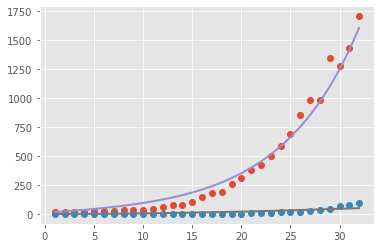

In [4]:
'''                                             PHASE 2                                              '''

# # # # # # # # # # # # # # # # # # # # # # # # Phase 2 array # # # # # # # # # # # # # # # # # # # #
model_select = np.zeros(shape=(32, 2)) #shape=(i, 2) i --> number of lines, 2 elements per line
data_select = np.zeros(shape=(32, 2))

# # # # # # # # # # # # # # # # # # ## # # # # Time Steps # # # # # # # # # # # # # # # # # # # #
t = np.linspace(1, 32, 32) 

# # # # # # # # # # # # Set up data # # # # # # # # # # 
#Phase 2 
dataI = np.array([15,15,20,20,22,28,28,31,34,34,42,59,79,79,103,145,177,189,258,311,377,425,503,588,688,850,985,985,1347,1275,1432,1703])
#No recovery data
dataD = np.array([0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,4,6,8,13,17,20,24,32,46,64,79,96])   
count = 0
for i in dataI:
    data = np.append(dataI[count], dataD[count])
    data_select[count] = data
    count+=1
    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
params = Parameters()
params.add('S0', value = float(14864428), vary=False)
params.add('L0', value = 10702388,  vary=False)
params.add('E0', value = 1, min=100, max=3000)
params.add('I0', value = float(15), vary=False)
params.add('Q0', value = 1, min=15, max=4000)
params.add('R0', value = float(0), vary=False)
params.add('D0', value = float(0), vary=False)
params.add('beta', value=0.01,  min=0, max=2)
params.add('zeta', value=0.01, min=0, max=1)
params.add('eta', value = 0,  vary=False)
params.add('delta', value = 0,  vary=False)
params.add('epsilon', value=0.01, min=0, max=1)
params.add('theta', value=0.01, min=0, max=1)
params.add('alpha', value=0.01, min=0, max=1)
params.add('omega', value=0.01, min=0, max=1)

result = minimize(residual_multi2, params, args=(t, data_select), method='leastsq')
final = data_select + result.residual.reshape(data_select.shape)

plt.plot(t, data_select, 'o')
plt.plot(t, final, '-', linewidth = 2);

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 359
    # data points      = 72
    # variables        = 7
    chi-square         = 600109.786
    reduced chi-square = 9232.45825
    Akaike info crit   = 664.030528
    Bayesian info crit = 679.967191
[[Variables]]
    S0:       1.486443e+07 (fixed)
    L0:       1.070239e+07 (fixed)
    E0:       17620.3429 +/- 67749.5654 (384.50%) (init = 1)
    I0:       1962 (fixed)
    Q0:       5004.60686 +/- 10474.5563 (209.30%) (init = 5000)
    R0:       831 (fixed)
    D0:       121 (fixed)
    beta:     1.99999986 +/- 6.99599681 (349.80%) (init = 0.01)
    zeta:     0.13 (fixed)
    eta:      0 (fixed)
    delta:    0 (fixed)
    epsilon:  0.03313295 +/- 0.11691886 (352.88%) (init = 0.01)
    theta:    0.14326480 +/- 0.13625604 (95.11%) (init = 0.01)
    alpha:    0.04596476 +/- 0.09910407 (215.61%) (init = 0.01)
    omega:    0.01375971 +/- 4.8635e-04 (3.53%) (init = 0.01)
[[Correlations]] (unreported correlation

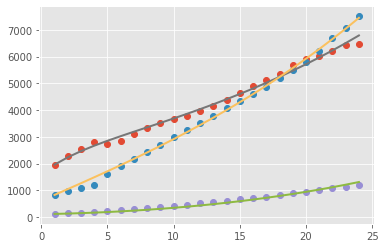

In [5]:
'''                                             PHASE 3                                              '''

# # # # # # # # # # # # # # # # # # # # # # # # Phase 3 array # # # # # # # # # # # # # # # # # # # #
model_select = np.zeros(shape=(24, 3)) #shape=(i, 3) i --> number of lines, 3 elements per line
data_select = np.zeros(shape=(24, 3))

# # # # # # # # # # # # # # # # # # ## # # # # Time step # # # # # # # # # # # # # # # # # # # #
t = np.linspace(1, 24, 24) 

# # # # # # # # # # # # Set up data # # # # # # # # # # 
#Phase 3
dataI = np.array([1962, 2294, 2539, 2819, 2723, 2831, 3110, 3322, 3529, 3669, 3799, 3949, 4161, 4384, 4627, 4920, 5135, 5369, 5669, 5929, 6024, 6199, 6432, 6486])
dataR = np.array([831,961,1091,1219,1624,1895,2166,2437,2708,2979,3250,3521,3792,4063,4334,4605,4875,5209,5515,5806,6221,6680,7087,7509])
dataD = np.array([121,144,172,202,232,265,302,344,377,418,463,512,553,610,663,715,764,843,897,955,1019,1072,1128,1188])
count = 0
for i in dataI:
    data = np.hstack(( dataI[count], dataR[count], dataD[count] )).ravel()
    data_select[count] = data
    count+=1
    
# # # # # # # # # # # # # # # # Set parameters # # # # # # # # # # # # # # # # 
params = Parameters()
params.add('S0', value = float(14864428), vary=False)
params.add('L0', value = 10702388,  vary=False) 
params.add('E0', value = 1, min=1, max=50000)
params.add('I0', value = float(1962), vary=False)
params.add('Q0', value = 1, min=5000, max=10000)
params.add('R0', value = float(831), vary=False)
params.add('D0', value = float(121), vary=False)
params.add('beta', value=0.01,  min=0, max=2)
params.add('zeta', value=float(0.13), vary=False) #value=0.01,  min=0, max=0.8
params.add('eta', value = 0,  vary=False)
params.add('delta', value = 0,  vary=False)
params.add('epsilon', value=0.01, min=0, max=1)
params.add('theta', value=0.01, min=0, max=1)
params.add('alpha', value=0.01, min=0, max=1)
params.add('omega', value=0.01, min=0, max=1)

# # # # # # # # # # # # # # # # Main Operation # # # # # # # # # # # # # # # # 
result = minimize(residual_multi3, params, args=(t, data_select), method='leastsq')
final = data_select + result.residual.reshape(data_select.shape)

plt.plot(t, data_select, 'o')
plt.plot(t, final, '-', linewidth = 2);

report_fit(result)
#End: E' = 38184; Q' = 11163

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 27
    # variables        = 5
    chi-square         = 53709.1939
    reduced chi-square = 2441.32700
    Akaike info crit   = 215.078570
    Bayesian info crit = 221.557755
[[Variables]]
    S0:       1.486443e+07 (fixed)
    L0:       1.070239e+07 (fixed)
    E0:       38184 (fixed)
    I0:       6432 (fixed)
    Q0:       11163 (fixed)
    R0:       8000 (fixed)
    D0:       1247 (fixed)
    beta:     1.02401160 +/- 0.09826678 (9.60%) (init = 0.01)
    zeta:     0.13 (fixed)
    eta:      0 (fixed)
    delta:    0 (fixed)
    epsilon:  0.02493936 +/- 0.00277347 (11.12%) (init = 0.01)
    theta:    0.15493598 +/- 0.01589184 (10.26%) (init = 0.01)
    alpha:    0.05034816 +/- 0.00138743 (2.76%) (init = 0.01)
    omega:    0.00587364 +/- 3.5461e-04 (6.04%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(epsilon, theta) =  0.979
    C(theta, alpha)   = -0.

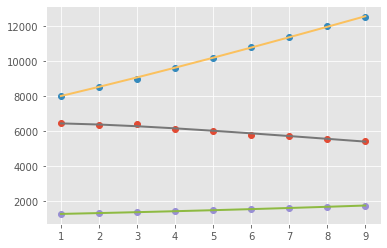

In [6]:
'''                                             PHASE 4                                              '''

# # # # # # # # # # # # # # # # # # # # # # # # Phase 4 array # # # # # # # # # # # # # # # # # # # #
model_select = np.zeros(shape=(9, 3)) #shape=(i, 3) i --> number of lines, 3 elements per line
data_select = np.zeros(shape=(9, 3))

# # # # # # # # # # # # # # # # # # ## # # # # Time step # # # # # # # # # # # # # # # # # # # #
t = np.linspace(1, 9, 9) 

# # # # # # # # # # # # Set up data # # # # # # # # # # 
#Phase 4
dataI = np.array([6432,6331,6417,6116,5982,5783,5729,5548,5418])
dataR = np.array([8000,8525,8964,9612,10205,10825,11390,12005,12505])
dataD = np.array([1247,1309,1358,1418,1476,1534,1589,1654,1703])
count = 0
for i in dataI:
    data = np.hstack(( dataI[count], dataR[count], dataD[count] )).ravel()
    data_select[count] = data
    count+=1
    
# # # # # # # # # # # # # # # # Set parameters # # # # # # # # # # # # # # # # 
params = Parameters()
params.add('S0', value = float(14864428), vary=False)
params.add('L0', value = 10702388,  vary=False) 
params.add('E0', value =float(38184), vary=False)
params.add('I0', value = float(6432), vary=False)
params.add('Q0', value = float(11163), vary=False)
params.add('R0', value = float(8000), vary=False)
params.add('D0', value = float(1247), vary=False)
params.add('beta', value=0.01,  min=0, max=2)
params.add('zeta', value=float(0.13), vary=False)
params.add('eta', value = 0,  vary=False)
params.add('delta', value = 0,  vary=False)
params.add('epsilon', value=0.01, min=0, max=1)
params.add('theta', value=0.01, min=0, max=1)
params.add('alpha', value=0.01, min=0, max=1)
params.add('omega', value=0.01, min=0, max=1)

# # # # # # # # # # # # # # # # Main Operation # # # # # # # # # # # # # # # # 
result = minimize(residual_multi3, params, args=(t, data_select), method='leastsq')
final = data_select + result.residual.reshape(data_select.shape)

plt.plot(t, data_select, 'o')
plt.plot(t, final, '-', linewidth = 2);

report_fit(result)
#End: E' = 27038; Q' = 13525

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 39
    # variables        = 5
    chi-square         = 51437.7555
    reduced chi-square = 1512.87516
    Akaike info crit   = 290.198077
    Bayesian info crit = 298.515885
[[Variables]]
    S0:       1.486443e+07 (fixed)
    L0:       1.070239e+07 (fixed)
    E0:       27038 (fixed)
    I0:       5531 (fixed)
    Q0:       13525 (fixed)
    R0:       12779 (fixed)
    D0:       1738 (fixed)
    beta:     0.91663985 +/- 0.06631574 (7.23%) (init = 0.01)
    zeta:     0.13 (fixed)
    eta:      0 (fixed)
    delta:    0 (fixed)
    epsilon:  0.01423452 +/- 0.00157738 (11.08%) (init = 0.01)
    theta:    0.06556908 +/- 0.00743046 (11.33%) (init = 0.01)
    alpha:    0.03156650 +/- 4.9747e-04 (1.58%) (init = 0.01)
    omega:    0.00229981 +/- 1.0448e-04 (4.54%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(epsilon, theta) =  0.976
    C(theta, alpha)   = -0

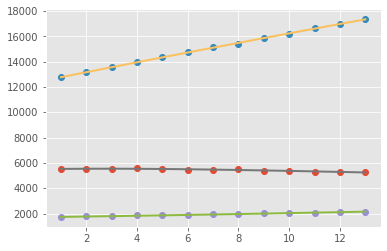

In [7]:
'''                                             PHASE 5                                              '''

# # # # # # # # # # # # # # # # # # # # # # # # Phase 5 array # # # # # # # # # # # # # # # # # # # #
model_select = np.zeros(shape=(13, 3)) #shape=(i, 3) i --> number of lines, 3 elements per line
data_select = np.zeros(shape=(13, 3))

# # # # # # # # # # # # # # # # # # ## # # # # Time step # # # # # # # # # # # # # # # # # # # #
t = np.linspace(1, 13, 13)

# # # # # # # # # # # # Set up data # # # # # # # # # # 
#Phase 5
dataI = np.array([5531,5500,5552,5608,5561,5466,5415,5516,5391,5377,5281,5293,5293])
dataR = np.array([12779,13222,13569,13990,14383,14772,15131,15391,15845,16204,16641,17020,17360])
dataD = np.array([1738,1777,1818,1855,1890,1927,1963,1992,2018,2042,2068,2093,2111])
count = 0
for i in dataI:
    data = np.hstack(( dataI[count], dataR[count], dataD[count] )).ravel()
    data_select[count] = data
    count+=1
    
# # # # # # # # # # # # # # # # Set parameters # # # # # # # # # # # # # # # # 
params = Parameters()
params.add('S0', value = float(14864428), vary=False)
params.add('L0', value = float(10702388),  vary=False) 
params.add('E0', value = float(27038), vary=False)
params.add('I0', value = float(5531), vary=False)
params.add('Q0', value = float(13525), vary=False)
params.add('R0', value = float(12779), vary=False)
params.add('D0', value = float(1738), vary=False)
params.add('beta', value=0.01,  min=0, max=2)
params.add('zeta', value=float(0.13), vary=False)
params.add('eta', value = 0,  vary=False)
params.add('delta', value = 0,  vary=False)
params.add('epsilon', value=0.01, min=0, max=1)
params.add('theta', value=0.01, min=0, max=1)
params.add('alpha', value=0.01, min=0, max=1)
params.add('omega', value=0.01, min=0, max=1)

# # # # # # # # # # # # # # # # Main Operation # # # # # # # # # # # # # # # # 
result = minimize(residual_multi3, params, args=(t, data_select), method='leastsq')
final = data_select + result.residual.reshape(data_select.shape)

plt.plot(t, data_select, 'o')
plt.plot(t, final, '-', linewidth = 2);

report_fit(result)
#End: E' = 21187; Q' = 12824

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 69
    # variables        = 5
    chi-square         = 264205.954
    reduced chi-square = 4128.21803
    Akaike info crit   = 579.276061
    Bayesian info crit = 590.446594
[[Variables]]
    S0:       1.486443e+07 (fixed)
    L0:       1.070239e+07 (fixed)
    E0:       21187 (fixed)
    I0:       5319 (fixed)
    Q0:       12824 (fixed)
    R0:       17638 (fixed)
    D0:       2146 (fixed)
    beta:     0.77623383 +/- 0.02124788 (2.74%) (init = 0.01)
    zeta:     0.13 (fixed)
    eta:      0 (fixed)
    delta:    0 (fixed)
    epsilon:  0.03234524 +/- 0.00113887 (3.52%) (init = 0.01)
    theta:    0.08822074 +/- 0.00387254 (4.39%) (init = 0.01)
    alpha:    0.02384470 +/- 3.5150e-04 (1.47%) (init = 0.01)
    omega:    0.00101683 +/- 5.1412e-05 (5.06%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(theta, alpha)   = -0.935
    C(epsilon, theta) =  0.9

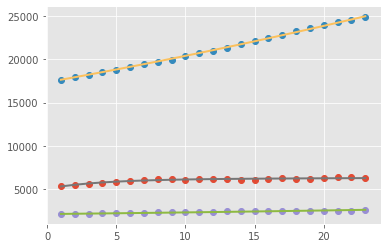

In [8]:
'''                                             PHASE 6                                              '''

# # # # # # # # # # # # # # # # # # # # # # # # Phase 6 array # # # # # # # # # # # # # # # # # # # #
model_select = np.zeros(shape=(23, 3)) #shape=(i, 3) i --> number of lines, 3 elements per line
data_select = np.zeros(shape=(23, 3))

# # # # # # # # # # # # # # # # # # ## # # # # Time step # # # # # # # # # # # # # # # # # # # #
t = np.linspace(1, 23, 23)

# # # # # # # # # # # # Set up data # # # # # # # # # # 
#Phase 6
dataI = np.array([5319,5486,5584,5678,5861,5894,6023,6206,6233,6111,6193,6227,6180,6049,6110,6225,6236,6195,6164,6255,6365,6368,6261])
dataR = np.array([17638,17898,18190,18509,18767,19146,19477,19698,19958,20372,20673,20983,21353,21810,22153,22484,22811,23208,23583,23947,24252,24492,24829])
dataD = np.array([2146,2173,2194,2219,2238,2264,2287,2311,2350,2376,2395,2416,2435,2445,2457,2465,2479,2495,2514,2522,2529,2534,2546,2550])
count = 0
for i in dataI:
    data = np.hstack(( dataI[count], dataR[count], dataD[count] )).ravel()
    data_select[count] = data
    count+=1
    
# # # # # # # # # # # # # # # # Set parameters # # # # # # # # # # # # # # # # 
params = Parameters()
params.add('S0', value = float(14864428), vary=False)
params.add('L0', value = float(10702388),  vary=False) 
params.add('E0', value = float(21187), vary=False)
params.add('I0', value = float(5319), vary=False)
params.add('Q0', value = float(12824), vary=False)
params.add('R0', value = float(17638), vary=False)
params.add('D0', value = float(2146), vary=False)
params.add('beta', value=0.01,  min=0, max=2)
params.add('zeta', value=float(0.13), vary=False)
params.add('eta', value = 0,  vary=False)
params.add('delta', value = 0,  vary=False)
params.add('epsilon', value=0.01, min=0, max=1)
params.add('theta', value=0.01, min=0, max=1)
params.add('alpha', value=0.01, min=0, max=1)
params.add('omega', value=0.01, min=0, max=1)

# # # # # # # # # # # # # # # # Main Operation # # # # # # # # # # # # # # # # 
result = minimize(residual_multi3, params, args=(t, data_select), method='leastsq')
final = data_select + result.residual.reshape(data_select.shape)

plt.plot(t, data_select, 'o')
plt.plot(t, final, '-', linewidth = 2);

report_fit(result)
#End: E' = 17340; Q' = 16801

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1452
    # data points      = 21
    # variables        = 5
    chi-square         = 73840.5397
    reduced chi-square = 4615.03373
    Akaike info crit   = 181.467956
    Bayesian info crit = 186.690568
[[Variables]]
    S0:       1.486443e+07 (fixed)
    L0:       1.070239e+07 (fixed)
    E0:       17340 (fixed)
    I0:       5961 (fixed)
    Q0:       16801 (fixed)
    R0:       25380 (fixed)
    D0:       2550 (fixed)
    beta:     1.99999993 +/- 13.1593209 (657.97%) (init = 0.01)
    zeta:     0.13 (fixed)
    eta:      0 (fixed)
    delta:    0 (fixed)
    epsilon:  0.00737710 +/- 0.02231734 (302.52%) (init = 0.01)
    theta:    0.06301257 +/- 0.06404991 (101.65%) (init = 0.01)
    alpha:    0.02236601 +/- 0.00131837 (5.89%) (init = 0.01)
    omega:    2.8183e-04 +/- 2.7101e-04 (96.16%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(epsilon, theta) =  0.995
    C(beta, epsilon

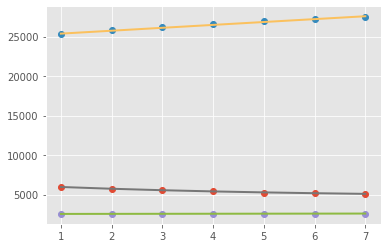

In [9]:
'''                                             PHASE 7                                              '''

# # # # # # # # # # # # # # # # # # # # # # # # Phase 7 array # # # # # # # # # # # # # # # # # # # #
model_select = np.zeros(shape=(7, 3)) #shape=(i, 3) i --> number of lines, 3 elements per line
data_select = np.zeros(shape=(7, 3))

# # # # # # # # # # # # # # # # # # ## # # # # Time step # # # # # # # # # # # # # # # # # # # #
t = np.linspace(1, 7, 7) 

# # # # # # # # # # # # Set up data # # # # # # # # # # 
#Phase 7
dataI = np.array([5961,5659,5539,5454,5228,5157,5123])
dataR = np.array([25380,25885,26187,26538,26961,27213,27431])
dataD = np.array([2550,2559,2564,2573,2580,2584,2588])
count = 0
for i in dataI:
    data = np.hstack(( dataI[count], dataR[count], dataD[count] )).ravel()
    data_select[count] = data
    count+=1
    
# # # # # # # # # # # # # # # # Set parameters # # # # # # # # # # # # # # # # 
params = Parameters()
params.add('S0', value = float(14864428), vary=False)
params.add('L0', value = float(10702388),  vary=False) 
params.add('E0', value = float(17340), vary=False)
params.add('I0', value = float(5961), vary=False)
params.add('Q0', value = float(16801), vary=False)
params.add('R0', value = float(25380), vary=False)
params.add('D0', value = float(2550), vary=False)
params.add('beta', value=0.01,  min=0, max=2)
params.add('zeta', value=float(0.13), vary=False)
params.add('eta', value = 0,  vary=False)
params.add('delta', value = 0,  vary=False)
params.add('epsilon', value=0.01, min=0, max=1)
params.add('theta', value=0.01, min=0, max=1)
params.add('alpha', value=0.01, min=0, max=1)
params.add('omega', value=0.01, min=0, max=1)

# # # # # # # # # # # # # # # # Main Operation # # # # # # # # # # # # # # # # 
result = minimize(residual_multi3, params, args=(t, data_select), method='leastsq')
final = data_select + result.residual.reshape(data_select.shape)

plt.plot(t, data_select, 'o')
plt.plot(t, final, '-', linewidth = 2);

report_fit(result)
#End: E' = 17340; Q' = 16801

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 90
    # variables        = 5
    chi-square         = 2091463.21
    reduced chi-square = 24605.4495
    Akaike info crit   = 914.820833
    Bayesian info crit = 927.319881
[[Variables]]
    S0:       1.486443e+07 (fixed)
    L0:       1.070239e+07 (fixed)
    E0:       21187 (fixed)
    I0:       5319 (fixed)
    Q0:       12824 (fixed)
    R0:       17638 (fixed)
    D0:       2146 (fixed)
    beta:     0.58538794 +/- 0.02908198 (4.97%) (init = 0.01)
    zeta:     0.13 (fixed)
    eta:      0 (fixed)
    delta:    0 (fixed)
    epsilon:  0.03628506 +/- 0.00170621 (4.70%) (init = 0.01)
    theta:    0.08465799 +/- 0.00496004 (5.86%) (init = 0.01)
    alpha:    0.02387669 +/- 5.9249e-04 (2.48%) (init = 0.01)
    omega:    8.4494e-04 +/- 7.9923e-05 (9.46%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(theta, alpha)   = -0.933
    C(epsilon, theta) =  0.8

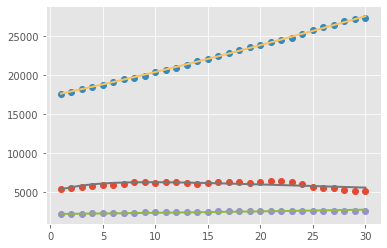

In [10]:
'''                                *PHASE 6* Combined the prevuious 6 and 7                                             '''

# # # # # # # # # # # # # # # # # # # # # # # # Phase 6 array # # # # # # # # # # # # # # # # # # # #
model_select = np.zeros(shape=(30, 3)) #shape=(i, 3) i --> number of lines, 3 elements per line
data_select = np.zeros(shape=(30, 3))

# # # # # # # # # # # # # # # # # # ## # # # # Time step # # # # # # # # # # # # # # # # # # # #
t = np.linspace(1, 30, 30) 

# # # # # # # # # # # # Set up data # # # # # # # # # # 
#Phase 6*
dataI = np.array([5319,5486,5584,5678,5861,5894,6023,6206,6233,6111,6193,6227,6180,6049,6110,6225,6236,6195,6164,6255,6365,6368,6261,5961,5659,5539,5454,5228,5157,5123])
dataR = np.array([17638,17898,18190,18509,18767,19146,19477,19698,19958,20372,20673,20983,21353,21810,22153,22484,22811,23208,23583,23947,24252,24492,24829,25380,25885,26187,26538,26961,27213,27431])
dataD = np.array([2146,2173,2194,2219,2238,2264,2287,2311,2350,2376,2395,2416,2435,2445,2457,2465,2479,2495,2514,2522,2529,2534,2546,2550,2550,2559,2564,2573,2580,2584,2588])
count = 0
for i in dataI:
    data = np.hstack(( dataI[count], dataR[count], dataD[count] )).ravel()
    data_select[count] = data
    count+=1
    
# # # # # # # # # # # # # # # # Set parameters # # # # # # # # # # # # # # # # 
params = Parameters()
params.add('S0', value = float(14864428), vary=False)
params.add('L0', value = float(10702388),  vary=False) 
params.add('E0', value = float(21187), vary=False)
params.add('I0', value = float(5319), vary=False)
params.add('Q0', value = float(12824), vary=False)
params.add('R0', value = float(17638), vary=False)
params.add('D0', value = float(2146), vary=False)
params.add('beta', value=0.01,  min=0, max=2)
params.add('zeta', value=float(0.13), vary=False)
params.add('eta', value = 0,  vary=False)
params.add('delta', value = 0,  vary=False)
params.add('epsilon', value=0.01, min=0, max=1)
params.add('theta', value=0.01, min=0, max=1)
params.add('alpha', value=0.01, min=0, max=1)
params.add('omega', value=0.01, min=0, max=1)

# # # # # # # # # # # # # # # # Main Operation # # # # # # # # # # # # # # # # 
result = minimize(residual_multi3, params, args=(t, data_select), method='leastsq')
final = data_select + result.residual.reshape(data_select.shape)

plt.plot(t, data_select, 'o')
plt.plot(t, final, '-', linewidth = 2);

report_fit(result)
#End: E' = ; Q' = 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 66
    # variables        = 5
    chi-square         = 817060.103
    reduced chi-square = 13394.4279
    Akaike info crit   = 631.971671
    Bayesian info crit = 642.919945
[[Variables]]
    S0:       1.486443e+07 (fixed)
    L0:       1.070239e+07 (fixed)
    E0:       38184 (fixed)
    I0:       6432 (fixed)
    Q0:       11163 (fixed)
    R0:       8000 (fixed)
    D0:       1247 (fixed)
    beta:     2.00000000 +/- 0.09861005 (4.93%) (init = 0.01)
    zeta:     0.13 (fixed)
    eta:      0 (fixed)
    delta:    0 (fixed)
    epsilon:  0.00488836 +/- 5.8897e-04 (12.05%) (init = 0.01)
    theta:    0.04984491 +/- 0.00283448 (5.69%) (init = 0.01)
    alpha:    0.05701040 +/- 9.5052e-04 (1.67%) (init = 0.01)
    omega:    0.00381358 +/- 1.6609e-04 (4.36%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(theta, alpha)   = -0.870
    C(beta, epsilon)  = -0.

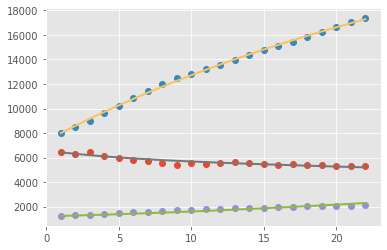

In [11]:
'''                               *PHASE 4* (Combined the previous 4 and 5)  INCONSISTENT                              '''

# # # # # # # # # # # # # # # # # # # # # # # # Phase 4* array # # # # # # # # # # # # # # # # # # # #
model_select = np.zeros(shape=(22, 3)) #shape=(i, 3) i --> number of lines, 3 elements per line
data_select = np.zeros(shape=(22, 3))

# # # # # # # # # # # # # # # # # # ## # # # # Time step # # # # # # # # # # # # # # # # # # # #
t = np.linspace(1, 22, 22)

# # # # # # # # # # # # Set up data # # # # # # # # # # 
#Phase 4*
dataI = np.array([6432,6331,6417,6116,5982,5783,5729,5548,5418,5531,5500,5552,5608,5561,5466,5415,5516,5391,5377,5281,5293,5293])
dataR = np.array([8000,8525,8964,9612,10205,10825,11390,12005,12505,12779,13222,13569,13990,14383,14772,15131,15391,15845,16204,16641,17020,17360])
dataD = np.array([1247,1309,1358,1418,1476,1534,1589,1654,1703,1738,1777,1818,1855,1890,1927,1963,1992,2018,2042,2068,2093,2111])
count = 0
for i in dataI:
    data = np.hstack(( dataI[count], dataR[count], dataD[count] )).ravel()
    data_select[count] = data
    count+=1
    
# # # # # # # # # # # # # # # # Set parameters # # # # # # # # # # # # # # # # 
params = Parameters()
params.add('S0', value = float(14864428), vary=False)
params.add('L0', value = 10702388,  vary=False) 
params.add('E0', value =float(38184), vary=False)
params.add('I0', value = float(6432), vary=False)
params.add('Q0', value = float(11163), vary=False)
params.add('R0', value = float(8000), vary=False)
params.add('D0', value = float(1247), vary=False)
params.add('beta', value=0.01,  min=0, max=2)
params.add('zeta', value=float(0.13), vary=False)
params.add('eta', value = 0,  vary=False)
params.add('delta', value = 0,  vary=False)
params.add('epsilon', value=0.01, min=0, max=1)
params.add('theta', value=0.01, min=0, max=1)
params.add('alpha', value=0.01, min=0, max=1)
params.add('omega', value=0.01, min=0, max=1)

# # # # # # # # # # # # # # # # Main Operation # # # # # # # # # # # # # # # # 
result = minimize(residual_multi3, params, args=(t, data_select), method='leastsq')
final = data_select + result.residual.reshape(data_select.shape)

plt.plot(t, data_select, 'o')
plt.plot(t, final, '-', linewidth = 2);

report_fit(result)

In [12]:
'''                                                      Data Sets                                                  '''
#population = 14864428
    
#Phase 1 small numbers
print('Phase 1: January 31st to April 1st. ')
data = np.array([3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,5,6,6,8])

#Phase 2 
print('Phase 2: March 1st to April 1st. 32 days in total. Day #: 30 - 62')
t = np.linspace(1, 32, 32)
dataI = np.array([15,15,20,20,22,28,28,31,34,34,42,59,79,79,103,145,177,189,258,311,377,425,503,588,688,850,985,985,1347,1275,1432,1703])
dataD = np.array([0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,4,6,8,13,17,20,24,32,46,64,79,96])
#No recovery data

#Phase 3
print('Phase 3: April 2nd to April 25th. 24 Days in total. Day #: 62 - 85')
t = np.linspace(1, 24, 24)
dataI = np.array([1962, 2294, 2539, 2819, 2723, 2831, 3110, 3322, 3529, 3669, 3799, 3949, 4161, 4384, 4627, 4920, 5135, 5369, 5669, 5929, 6024, 6199, 6432, 6486])
dataR = np.array([831,961,1091,1219,1624,1895,2166,2437,2708,2979,3250,3521,3792,4063,4334,4605,4875,5209,5515,5806,6221,6680,7087,7509])
dataD = np.array([121,144,172,202,232,265,302,344,377,418,463,512,553,610,663,715,764,843,897,955,1019,1072,1128,1188])

#Phase 4
print('Phase 4: April 26th to May 4th. 9 Days in totaL. Day #: 86 - 94')
t = np.linspace(1,9,9)
dataI = np.array([6432,6331,6417,6116,5982,5783,5729,5548,5418])
dataR = np.array([8000,8525,8964,9612,10205,10825,11390,12005,12505])
dataD = np.array([1247,1309,1358,1418,1476,1534,1589,1654,1703])

#Phase 5
print('Phase 5: May 5th to May 17th. 13 Days in total. Day #: 95 - 107')
t = np.linspace(1, 13, 13)
dataI = np.array([5531,5500,5552,5608,5561,5466,5415,5516,5391,5377,5281,5293,5293])
dataR = np.array([12779,13222,13569,13990,14383,14772,15131,15391,15845,16204,16641,17020,17360])
dataD = np.array([1738,1777,1818,1855,1890,1927,1963,1992,2018,2042,2068,2093,2111])

#Phase 6
print('Phase 6: May 18 to June 9. 23 Days in total. Day #: 108 - 130')
t = np.linspace(1, 23, 23)
dataI = np.array([5319,5486,5584,5678,5861,5894,6023,6206,6233,6111,6193,6227,6180,6049,6110,6225,6236,6195,6164,6255,6365,6368,6261])
dataR = np.array([17638,17898,18190,18509,18767,19146,19477,19698,19958,20372,20673,20983,21353,21810,22153,22484,22811,23208,23583,23947,24252,24492,24829])
dataD = np.array([2146,2173,2194,2219,2238,2264,2287,2311,2350,2376,2395,2416,2435,2445,2457,2465,2479,2495,2514,2522,2529,2534,2546,2550])

#Phase 7
print('Phase 7: June 10 to June 16*. 7 Days in total. Day #: 131 - 137')
t = np.linspace(1, 7, 7)
dataI = np.array([5961,5659,5539,5454,5228,5157,5123])
dataR = np.array([25380,25885,26187,26538,26961,27213,27431])
dataD = np.array([2550,2559,2564,2573,2580,2584,2588])

Phase 1: January 31st to April 1st. 
Phase 2: March 1st to April 1st. 32 days in total. Day #: 30 - 62
Phase 3: April 2nd to April 25th. 24 Days in total. Day #: 62 - 85
Phase 4: April 26th to May 4th. 9 Days in totaL. Day #: 86 - 94
Phase 5: May 5th to May 17th. 13 Days in total. Day #: 95 - 107
Phase 6: May 18 to June 9. 23 Days in total. Day #: 108 - 130
Phase 7: June 10 to June 16*. 7 Days in total. Day #: 131 - 137
